# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [31]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import progressbar
from ast import literal_eval
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# magic word for producing visualizations in notebook
%matplotlib inline

# Part 0: Get to Know the Data¶

In [14]:
#load in the data
azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
customers = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

In [3]:
print(azdias.shape)
azdias.head()
azdias.drop(azdias.columns[0], axis=1)

(891221, 367)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


In [5]:
print(customers.shape)
customers.head()
customers.drop(customers.columns[0], axis=1)

(191652, 370)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
5,143888,1,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,6.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
6,143904,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
7,143910,1,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,1.0,6.0,9.0,3.0,3,FOOD,SINGLE_BUYER,0,1,4
8,102160,2,3.0,5.0,NaN,NaN,NaN,NaN,4.0,74.0,...,9.0,6.0,3.0,4.0,3,COSMETIC,MULTI_BUYER,0,2,4
9,102173,1,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,...,4.0,2.0,9.0,5.0,1,COSMETIC,MULTI_BUYER,0,1,3


# Part 1: Customer Segmentation Report
The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.



## Step 1: Preprocessing
### Step 1.1: Assess Missing Data
The feature summary file from the previous project contains a summary of properties for each demographics data column. The additional columns found in this project will be assessed manually to complete the rest of the properties. The file DIAS Attributes - Values 2017.xlsx will be studied for this assessment. This will help make cleaning decisions during this stage of the project.

In [11]:
# Load in the feature summary file.
feat_info = pd.read_csv('./data/new_features.csv')

In [186]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown,Comment
0,AGER_TYP,person,categorical,"[-1,0]",NaN
1,ALTER_HH,household,interval,[0],NaN
2,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",NaN
3,ANREDE_KZ,person,categorical,"[-1,0]",NaN
4,ANZ_HAUSHALTE_AKTIV,building,numeric,[0],NaN


In [7]:
feat_info.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 5 columns):
attribute             314 non-null object
information_level     274 non-null object
type                  314 non-null object
missing_or_unknown    314 non-null object
Comment               15 non-null object
dtypes: object(5)
memory usage: 12.3+ KB


In [12]:
# Set attribute as index for `feat_info` dataframe
feat_info.set_index('attribute', inplace=True)

In [15]:
# Delete columns found in the features not found in the general population dataframe
feat_extra = np.setdiff1d(feat_info.index, azdias.columns, assume_unique=True)
feat_info.drop(feat_extra, inplace=True)
feat_info.shape

(272, 4)

In [16]:
# Check remaining missing columns in the feature summary file
feat_missing = np.setdiff1d(azdias.columns, feat_info.index, assume_unique=True)
print('There are {} missing features.'.format(len(feat_missing)))
feat_missing

There are 95 missing features.


array(['Unnamed: 0', 'LNR', 'AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2',
       'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'CAMEO_INTL_2015',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3',
       'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_DIREKT',
       'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST',
       'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG',
       'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL',
       'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
       'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
       'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_MOBILE',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_TEL

In [17]:
# Create new dataframe of missing features
feat_missing = pd.DataFrame(feat_missing, columns=['attribute'])
feat_missing['information_level'] = np.NaN
feat_missing['type'] = np.NaN
feat_missing['missing_or_unknown'] = '[]'
feat_missing.set_index('attribute', inplace=True)
print('There are {} rows and {} columns.'.format(feat_missing.shape[0], feat_missing.shape[1]))
feat_missing.head()

There are 95 rows and 3 columns.


,information_level,type,missing_or_unknown
attribute,,,
Unnamed: 0,NaN,NaN,[]
LNR,NaN,NaN,[]
AKT_DAT_KL,NaN,NaN,[]
ALTER_KIND1,NaN,NaN,[]
ALTER_KIND2,NaN,NaN,[]


#### Step 1.1.1: Convert Missing Value Codes to NaNs
For simplicity, it will be assumed that there are no missing values in the feat_missing columns. Some columns in the feat_info dataframe do not have missing values too so this assumption makes sense. The column type will be examined later once an assessment of missing data is completed.

In [18]:
# Add dataframe of missing features to the original features information dataframe
feat_info = feat_info.append(feat_missing)
print('There are {} rows and {} columns.'.format(feat_info.shape[0], feat_info.shape[1]))
feat_info.head()

There are 367 rows and 4 columns.


/Users/zhongming/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,Comment,information_level,missing_or_unknown,type
attribute,,,,
AGER_TYP,NaN,person,"[-1,0]",categorical
ALTER_HH,NaN,household,[0],interval
ALTERSKATEGORIE_GROB,NaN,person,"[-1,0,9]",ordinal
ANREDE_KZ,NaN,person,"[-1,0]",categorical
ANZ_HAUSHALTE_AKTIV,NaN,building,[0],numeric


In [19]:
# This should be null
np.setdiff1d(azdias.columns, feat_info.index, assume_unique=True)

array([], dtype=object)

In [20]:
feat_info.missing_or_unknown.value_counts()

[-1]        127
[]          121
[-1,9]       75
[-1,0]       17
[0]          12
[10]         12
[-1,X]        1
[XX]          1
[-1,0,9]      1
Name: missing_or_unknown, dtype: int64

In [21]:
# Prepare array of strings containing X for parsing 

feat_info.missing_or_unknown = feat_info.missing_or_unknown.replace('[XX]', "['XX']")
feat_info.missing_or_unknown = feat_info.missing_or_unknown.replace('[-1,X]', "[-1,'X']")

# Convert string representation to a list
feat_info.missing_or_unknown = feat_info.missing_or_unknown.apply(literal_eval)

In [270]:
for column in azdias:
    mask = azdias[column].isin(feat_info.at[column, 'missing_or_unknown'])
    azdias.at[mask, column] = np.NaN

for attribute in feat_info.index:
        if attribute in azdias.columns:
            keys_array = feat_info.loc[attribute,'missing_or_unknown']
            #print(attribute, keys_array)
            for key in keys_array:
                if key == 'X' or key == 'XX':
                    key = str(key)
                else:
                    key = int(key)
                    #df[attribute].value_counts()
                azdias[attribute].replace(key, np.NaN, inplace=True)

        else:
            print("Attribute {} is not available in DataFrame.".format(attribute))


In [154]:
# Visually check for conversion
azdias.isnull().sum()

Unnamed: 0                         0
LNR                                0
AGER_TYP                      685843
AKT_DAT_KL                     73499
ALTER_HH                      310267
ALTER_KIND1                   810163
ALTER_KIND2                   861722
ALTER_KIND3                   885051
ALTER_KIND4                   890016
ALTERSKATEGORIE_FEIN          262947
ANZ_HAUSHALTE_AKTIV            99611
ANZ_HH_TITEL                   97008
ANZ_KINDER                     73499
ANZ_PERSONEN                   73499
ANZ_STATISTISCHE_HAUSHALTE     93148
ANZ_TITEL                      73499
ARBEIT                         97216
BALLRAUM                       93740
CAMEO_DEU_2015                 99352
CAMEO_DEUG_2015                99352
CAMEO_INTL_2015                98979
CJT_GESAMTTYP                   4854
CJT_KATALOGNUTZER               4854
CJT_TYP_1                       4854
CJT_TYP_2                       4854
CJT_TYP_3                       4854
CJT_TYP_4                       4854
C

#### Step 1.1.2: Assess Missing Data in Each Column
There will be few columns that are outliers in terms of the proportion of values that are missing. Matplotlib's hist() function will be used to visualize the distribution of missing value counts to find these columns. For simplicity, these columns will be removed from the dataframe.

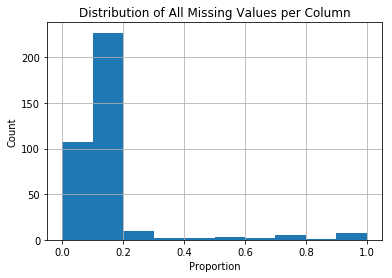

In [271]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_col = azdias.isnull().sum()/azdias.shape[0]

missing_col.hist()
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Column');

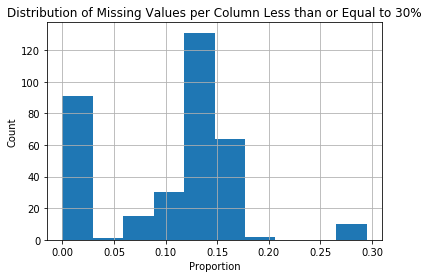

In [272]:
# Investigate patterns in the amount of missing data in each column.
missing_col_sub = missing_col[missing_col <= 0.3]

missing_col_sub.hist()
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of Missing Values per Column Less than or Equal to 30%');

In [273]:
# Remove the outlier columns from the dataset. (Other data engineering
# tasks such as re-encoding and imputation will be done later.)
col_outlier = missing_col[missing_col > 0.3].index
azdias_sub = azdias.drop(col_outlier, axis=1)

# Show column outliers
col_outlier

Index(['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_DATUM', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX',
       'KK_KUNDENTYP', 'TITEL_KZ'],
      dtype='object')

In [274]:
# Remove the outlier attributes from `feat_info`
feat_info_new = feat_info[feat_info.index.isin(col_outlier) == False]
feat_info_new.shape

(344, 4)

#### Discussion 1.1.2: Assess Missing Data in Each Column
The distribution of the amount of missing data is skewed to the right. Most of the columns have less than or equal to 30% missing data. For the columns less than or equal to 30%, there are two distinct patterns. The first pattern is an almost single bar for no missing values. The second pattern has a slightly normal distribution for missing values less than 30% but not equal to 0. Columns which are related have missing values with almost similar proportions.

### Step 1.2: Select and Re-Encode Features
Checking for missing data isn't the only way to prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, a few encoding changes or additional assumptions will be made. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. The third column of the feature summary (feat_info) will be checked for a summary of types of measurement.

* As mentioned earlier, there are some column types which are unknown. They must be identified first before starting the other steps.
* For numeric and interval data, these features can be kept without changes.
* Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
* Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first part of this sub-step, the columns which have unknown types will be examined and assumptions will be made. Next, an investigation of the categorical and mixed-type features will be investigated and decider whether they will be kept, dropped, or re-encoded. Finally, in the last part, a new data frame will be created with only the selected and engineered columns.

In [275]:
# How many features are there of each data type?
print("There are {} columns which have missing data type.".format(feat_info_new['type'].isnull().sum()))
feat_info_new['type'].value_counts()

There are 89 columns which have missing data type.


ordinal        226
categorical     23
numeric          6
Name: type, dtype: int64

In [160]:
for col in feat_info_new[feat_info_new['type'].isnull()].index:
    print(azdias_sub[col].value_counts())

131071.0    1
403540.0    1
403551.0    1
403550.0    1
403549.0    1
403548.0    1
403547.0    1
403546.0    1
403545.0    1
403544.0    1
403543.0    1
403542.0    1
403541.0    1
403539.0    1
403580.0    1
403538.0    1
403537.0    1
25221.0     1
403535.0    1
403534.0    1
861757.0    1
403533.0    1
403532.0    1
403531.0    1
403530.0    1
403529.0    1
25222.0     1
403553.0    1
403554.0    1
403555.0    1
           ..
689908.0    1
689907.0    1
689930.0    1
689932.0    1
689957.0    1
689933.0    1
689956.0    1
689955.0    1
689954.0    1
689953.0    1
43122.0     1
689951.0    1
689950.0    1
356294.0    1
689948.0    1
689947.0    1
689946.0    1
689945.0    1
689944.0    1
689943.0    1
689942.0    1
689941.0    1
689940.0    1
689939.0    1
689938.0    1
689937.0    1
43121.0     1
689935.0    1
689934.0    1
0.0         1
Name: Unnamed: 0, Length: 891221, dtype: int64
1064150.0    1
479217.0     1
479228.0     1
479227.0     1
479226.0     1
479225.0     1
479224.0 

In [13]:
drop_feat = ['LNR', 'EINGEFUEGT_AM', 'VERDICHTUNGSRAUM','Unnamed: 0']

feat_numeric = ['ANZ_STATISTISCHE_HAUSHALTE']

feat_ordinal = ['AKT_DAT_KL',
                'ANZ_KINDER',
                'CJT_KATALOGNUTZER',
                'CJT_TYP_1',
                'CJT_TYP_2',
                'CJT_TYP_3',
                'CJT_TYP_4',
                'CJT_TYP_5',
                'CJT_TYP_6',
                'D19_KONSUMTYP_MAX',
                'D19_SOZIALES', 
                'D19_TELKO_ONLINE_QUOTE_12',
                'D19_VERSI_DATUM',
                'D19_VERSI_OFFLINE_DATUM',
                'D19_VERSI_ONLINE_DATUM',
                'D19_VERSI_ONLINE_QUOTE_12',
                'DSL_FLAG',
                'FIRMENDICHTE',
                'HH_DELTA_FLAG',
                'KBA13_ANTG1',
                'KBA13_ANTG2',
                'KBA13_ANTG3',
                'KBA13_ANTG4',
                'KBA13_BAUMAX',
                'KBA13_GBZ',
                'KBA13_HHZ',
                'KBA13_KMH_210',
                'KOMBIALTER',
                'KONSUMZELLE',
                'MOBI_RASTER',
                'RT_KEIN_ANREIZ',
                'RT_SCHNAEPPCHEN',
                'RT_UEBERGROESSE',
                'UMFELD_ALT',
                'UMFELD_JUNG',
                'UNGLEICHENN_FLAG',
                'VHA',
                'VHN',
                'VK_DHT4A',
                'VK_DISTANZ',
                'VK_ZG11',
                'D19_BANKEN_DIREKT',
                'D19_BANKEN_GROSS',
                'D19_BANKEN_LOKAL',
                'D19_BANKEN_REST',
                'D19_BEKLEIDUNG_GEH',
                'D19_BEKLEIDUNG_REST',
                'D19_BILDUNG',
                'D19_BIO_OEKO',
                'D19_BUCH_CD',
                'D19_DIGIT_SERV',
                'D19_DROGERIEARTIKEL',
                'D19_ENERGIE',
                'D19_FREIZEIT',
                'D19_GARTEN',
                'D19_HANDWERK',
                'D19_HAUS_DEKO',
                'D19_KINDERARTIKEL',
                'D19_KOSMETIK',
                'D19_LEBENSMITTEL',
                'D19_LOTTO',
                'D19_NAHRUNGSERGAENZUNG',
                'D19_RATGEBER',
                'D19_REISEN',
                'D19_SAMMELARTIKEL',
                'D19_SCHUHE',
                'D19_SONSTIGE',
                'D19_SOZIALES',
                'D19_TECHNIK',
                'D19_TELKO_MOBILE',
                'D19_TELKO_ONLINE_QUOTE_12',
                'D19_TELKO_REST',
                'D19_TIERARTIKEL',
                'D19_VERSAND_REST',
                'D19_VERSICHERUNGEN',
                'D19_VOLLSORTIMENT',
                'D19_WEIN_FEINKOST',
                'FIRMENDICHTE',
                'GEMEINDETYP',
                'KBA13_ANTG1',
                'KBA13_CCM_1401_2500',
                'DSL_FLAG',
                'HH_DELTA_FLAG',
                'UNGLEICHENN_FLAG',
                'ARBEIT'
                ]

feat_categorical = ['ALTERSKATEGORIE_FEIN',
                    'D19_LETZTER_KAUF_BRANCHE',
                    'EINGEZOGENAM_HH_JAHR',
                    'GEMEINDETYP',
                    'STRUKTURTYP',
                   'SOHO_KZ']
feat_mixed=['PRAEGENDE_JUGENDJAHRE',
            'LP_LEBENSPHASE_FEIN',
            'LP_LEBENSPHASE_GROB',
            'WOHNLAGE',
            'CAMEO_INTL_2015',
            'PLZ8_BAUMAX'
           ]

In [277]:
# Drop the four features
azdias_sub = azdias_sub.drop(drop_feat, axis=1)
feat_info_new = feat_info_new.drop(drop_feat, axis=0)
azdias_sub.shape[1], feat_info_new.shape[0] # should be the same

(340, 340)

In [278]:
# Fill the missing feature types
feat_info_new.loc[feat_numeric , 'type'] = 'numeric'
feat_info_new.loc[feat_ordinal, 'type'] = 'ordinal'
feat_info_new.loc[feat_categorical, 'type'] = 'categorical'
feat_info_new.loc[feat_mixed, 'type'] = 'mixed'

In [279]:
# How many features are there of each data type?
print("There are {} columns which have missing data type.".format(feat_info_new['type'].isnull().sum()))
feat_info_new['type'].value_counts()

There are 0 columns which have missing data type.


ordinal        303
categorical     24
numeric          7
mixed            6
Name: type, dtype: int64

In [280]:
feat_info_new[feat_info_new['type'].isnull()]

,Comment,information_level,missing_or_unknown,type
attribute,,,,


#### Step 1.2.1: Re-Encode Categorical Features
For categorical data, levels will be encoded as dummy variables. Depending on the number of categories, one of the following will be performed

For binary (two-level) categoricals that take numeric values, they will be kept without needing to do anything.
There is one binary variable that takes on non-numeric values. For this one, the values will be re-encoded as numbers.
For multi-level categoricals (three or more values), the values will be encoded using multiple dummy variables.

In [281]:
categorical = feat_info_new[feat_info_new['type'] == 'categorical']
# Check categorical variable whether it is binary or multi-level
binary = []
multi_level = []
for att in categorical.index:
    if len(azdias_sub[att].value_counts()) == 2:
        binary.append(att)
    else:
        multi_level.append(att)

In [282]:
binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'OST_WEST_KZ', 'VERS_TYP', 'SOHO_KZ']

In [283]:
multi_level

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CJT_GESAMTTYP',
 'D19_KONSUMTYP',
 'FINANZTYP',
 'GEBAEUDETYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'ALTERSKATEGORIE_FEIN',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEZOGENAM_HH_JAHR',
 'GEMEINDETYP',
 'STRUKTURTYP']

In [284]:
# Re-encode the values as numbers for `OST_WEST_KZ`
azdias_sub['OST_WEST_KZ'] = azdias_sub['OST_WEST_KZ'].replace({'O':1.0, 'W':2.0})

In [310]:
azdias_enc['OST_WEST_KZ'].value_counts()

2.0    629528
1.0    168545
Name: OST_WEST_KZ, dtype: int64

In [285]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_enc = pd.get_dummies(azdias_sub, columns=multi_level)

#### Step 1.2.2: Engineer Mixed-Type Features
There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis.

PRAEGENDE_JUGENDJAHRE - combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). Three new variables will be created to capture the other two dimensions: an interval-type variable for decade, and two binary variables for movement and nation.

CAMEO_INTL_2015 - combines information on two axes: wealth and life stage. The two-digit codes will be broken by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [286]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Engineer new column `DECADE`
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Engineer new column `DECADE`
azdias_enc['DECADE'] = azdias_enc['PRAEGENDE_JUGENDJAHRE']

# Engineer new column `MOVEMENT`
mainstream = [1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0]
avantgarde = [2.0, 4.0, 6.0, 7.0, 9.0, 11.0, 13.0, 15.0]
OO=[1.0,2.0,3.0,4.0,5.0,7.0,8.0,9.0,12.0,13.0,14.0,15.0]
WW=[1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,12.0,13.0,14.0,15.0]

main = azdias_enc['PRAEGENDE_JUGENDJAHRE'].isin(mainstream)
azdias_enc.loc[main, 'MOVEMENT'] = 1.0

avant = azdias_enc['PRAEGENDE_JUGENDJAHRE'].isin(avantgarde)
azdias_enc.loc[avant, 'MOVEMENT'] = 2.0

O=azdias_enc['PRAEGENDE_JUGENDJAHRE'].isin(OO)
azdias_enc.loc[O, 'NATIONO'] = 1.0
azdias_enc.loc[-O,'NATIONO'] = 0.0
W=azdias_enc['PRAEGENDE_JUGENDJAHRE'].isin(WW)
azdias_enc.loc[W, 'NATIONW'] = 1.0
azdias_enc.loc[-W,'NATIONW'] =0.0

In [287]:
azdias_enc['MOVEMENT'].value_counts()

1.0    607832
2.0    175225
Name: MOVEMENT, dtype: int64

In [288]:
azdias_enc['NATIONO'].value_counts()

1.0    635845
0.0    255376
Name: NATIONO, dtype: int64

In [289]:
azdias_enc['NATIONW'].value_counts()

1.0    661497
0.0    229724
Name: NATIONW, dtype: int64

In [290]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Engineer new column 'WEALTH'
azdias_enc['WEALTH'] = pd.to_numeric(azdias_enc['CAMEO_INTL_2015'],errors='coerce') // 10

# Engineer new column 'LIFE_STAGE'
azdias_enc['LIFE_STAGE'] = pd.to_numeric(azdias_enc['CAMEO_INTL_2015'],errors='coerce') % 10


In [291]:
# Check other categories
mixed = feat_info_new[feat_info_new['type'] == 'mixed']
mixed

,Comment,information_level,missing_or_unknown,type
attribute,,,,
LP_LEBENSPHASE_FEIN,NaN,person,[0],mixed
LP_LEBENSPHASE_GROB,NaN,person,[0],mixed
PLZ8_BAUMAX,NaN,macrocell_plz8,"[-1, 0]",mixed
PRAEGENDE_JUGENDJAHRE,NaN,person,"[-1, 0]",mixed
WOHNLAGE,NaN,building,"[-1, 0]",mixed
CAMEO_INTL_2015,NaN,NaN,[],mixed


In [292]:
# Re-encode `LP_LEBENSPHASE_GROB` and `WOHNLAGE` to be kept in the analysis.
azdias_engg = pd.get_dummies(azdias_enc, columns=['LP_LEBENSPHASE_GROB', 'WOHNLAGE'])

In [293]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_clean = azdias_engg.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN'], axis=1)

In [294]:
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 593 entries, AKT_DAT_KL to WOHNLAGE_8.0
dtypes: float64(322), uint8(271)
memory usage: 2.4 GB


### Step 1.3: Create Cleaning Function¶

In [9]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for column in df:
        if column == 'RESPONSE':
            pass
        else:
            mask = df[column].isin(feat_info.loc[column, 'missing_or_unknown'])
            df.loc[mask, column] = np.NaN          
        
    # remove selected columns and rows, ...
    col_outlier = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_DATUM', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX',
       'KK_KUNDENTYP', 'TITEL_KZ']
    df_sub = df.drop(col_outlier, axis=1)
    
    # drop additional columns
    df_sub = df_sub.drop(['LNR', 'EINGEFUEGT_AM', 'VERDICHTUNGSRAUM','Unnamed: 0'], axis=1)
    
    # select, re-encode, and engineer column values.
    df_sub['OST_WEST_KZ'] = df_sub['OST_WEST_KZ'].replace({'O':1.0, 'W':2.0})
    
    # change to float for the other three datasets
    df_sub['CAMEO_DEUG_2015'] = df_sub['CAMEO_DEUG_2015'].astype('float')
    
    categorical = [  'CAMEO_DEU_2015',
                     'CAMEO_DEUG_2015',
                     'CJT_GESAMTTYP',
                     'D19_KONSUMTYP',
                     'FINANZTYP',
                     'GEBAEUDETYP',
                     'GFK_URLAUBERTYP',
                     'LP_FAMILIE_FEIN',
                     'LP_FAMILIE_GROB',
                     'LP_STATUS_FEIN',
                     'LP_STATUS_GROB',
                     'NATIONALITAET_KZ',
                     'SHOPPER_TYP',
                     'ZABEOTYP',
                     'ALTERSKATEGORIE_FEIN',
                     'D19_LETZTER_KAUF_BRANCHE',
                     'EINGEZOGENAM_HH_JAHR',
                     'GEMEINDETYP',
                     'STRUKTURTYP',             
                     'LP_LEBENSPHASE_GROB', 
                     'WOHNLAGE']
    
    df_enc = pd.get_dummies(df_sub, columns=categorical)
    
    # Engineer mixed-type features
    df_enc['DECADE'] = df_enc['PRAEGENDE_JUGENDJAHRE']
    main = df_enc['PRAEGENDE_JUGENDJAHRE'].isin([1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0])
    df_enc.loc[main, 'MOVEMENT'] = 1.0
    avant = df_enc['PRAEGENDE_JUGENDJAHRE'].isin([2.0, 4.0, 6.0, 7.0, 9.0, 11.0, 13.0, 15.0])
    df_enc.loc[avant, 'MOVEMENT'] = 2.0
    O=df_enc['PRAEGENDE_JUGENDJAHRE'].isin([1.0,2.0,3.0,4.0,5.0,7.0,8.0,9.0,12.0,13.0,14.0,15.0])
    df_enc.loc[O, 'NATIONO'] = 1.0
    df_enc.loc[-O,'NATIONO'] = 0.0
    W=df_enc['PRAEGENDE_JUGENDJAHRE'].isin([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,12.0,13.0,14.0,15.0])
    df_enc.loc[W, 'NATIONW'] = 1.0
    df_enc.loc[-W,'NATIONW'] =0.0
    df_enc['WEALTH'] = pd.to_numeric(df_enc['CAMEO_INTL_2015'],errors='coerce') // 10
    df_enc['LIFE_STAGE'] = pd.to_numeric(df_enc['CAMEO_INTL_2015'],errors='coerce') % 10    
    df_clean = df_enc.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN'], axis=1)

    # Return the cleaned dataframe.
    return df_clean    

In [71]:
azdias_clean = clean_data(azdias)

In [24]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_null = azdias_clean[azdias_clean.isnull().any(axis=1)] # subset of missing data

# Compare shape between `azdias_clean` and its subset of missing data
(azdias_clean.shape, azdias_null.shape)

((891221, 584), (404662, 584))

## Step 2: Feature Transformation
### Step 2.1: Apply Feature Scaling
Before dimensionality reduction techniques are applied to the data, feature scaling must be performed so that the principal component vectors are not influenced by the natural differences in scale for features.

sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to the data, the DataFrame must be cleaned of the remaining missing values before applying the scaler. This was done by applying an Imputer to replace all missing values.
For the actual scaling function, a StandardScaler instance was done, scaling each feature to mean 0 and standard deviation 1.
For these classes, the .fit_transform() method was used to both fit a procedure to the data as well as apply the transformation to the data at the same time.

In [72]:
# Apply `Imputer` to replace all missing values with the mean
imputer = Imputer()
azdias_impute = imputer.fit_transform(azdias_clean)

/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [73]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_impute)

### Discussion 2.1: Apply Feature Scaling
For simplicity, all missing values were replaced by Imputer using the mean along the columns. There are 298,861 rows with missing values in their columns which is roughly 38% of the total number of rows so it is not advisable to drop these.

Feature scaling was then applied using StandardScaler instance from sklearn and the .fit_transform() method to fit the procedure to the data and apply the transformation at the same time. The instance returned an array for use in the next step which is PCA.



### Step 2.2: Perform Dimensionality Reduction
On the scaled data, dimensionality reduction techniques can now be applied.

sklearn's PCA class will be used to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, at least half the number of features will be set (so there's enough features to see the general trend in variability).
The ratio of variance explained by each principal component as well as the cumulative variance explained will be checked by plotting the cumulative or sequential values using matplotlib's plot() function. Based on the findings, a value for the number of transformed features will be retained for the clustering part of the project.
Once a choice for the number of components to keep has been made, the PCA instance will be re-fit to perform the decided-on transformation.

In [74]:
# Apply PCA to the data.
n_components = int(azdias_clean.shape[1] / 2) # Half the number of features

pca = PCA(n_components)
azdias_pca = pca.fit_transform(azdias_scaled)

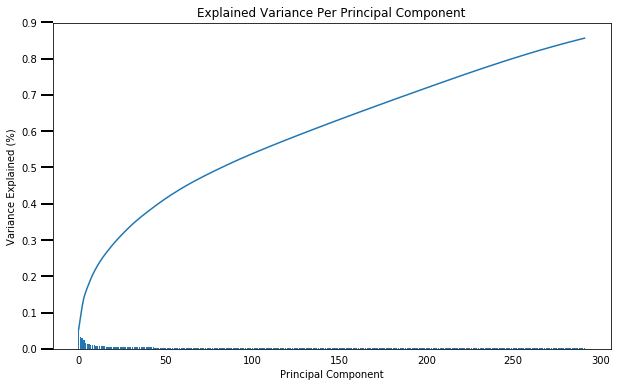

In [29]:
# Investigate the variance accounted for by each principal component.
ind = np.arange(n_components)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
ax = plt.subplot()
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)
for i in range(n_components):
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [30]:
sum(pca.explained_variance_ratio_)

0.8561954141981192

### Discussion 2.2: Perform Dimensionality Reduction
As suggested by the procedure, half of the number of features (297 out of 595) was used as the initial number of components for the principal component analysis of the data. As expected, the amount of original variability in the original data decreased per subsequent component. The 297 components can explain at least 86% of the variability in the original dataset. This is good enough for further analysis and no further re-application is necesssary.



### Step 2.3: Interpret Principal Components
Now that the principal components have been transformed, the weight of each variable on the first few components should be checked to see if they can be interpreted in some fashion.

Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

To investigate the features, each weight should be mapped to their corresponding feature name, then the features should be sorted according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list.



In [75]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Dimension indexing
dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# PCA components
components = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_clean.keys())
components.index = dimensions

In [32]:
components.iloc[0].sort_values(ascending=False)

MOBI_REGIO                    0.1384
PLZ8_ANTG1                    0.1340
KBA13_ANTG1                   0.1336
KBA05_ANTG1                   0.1284
MOBI_RASTER                   0.1271
KBA05_AUTOQUOT                0.1219
KBA05_GBZ                     0.1218
KBA13_AUTOQUOTE               0.1217
FINANZ_MINIMALIST             0.1089
KBA13_GBZ                     0.0999
PLZ8_GBZ                      0.0988
KBA13_ALTERHALTER_60          0.0965
KBA05_ANHANG                  0.0957
KONSUMNAEHE                   0.0956
KBA13_HALTER_55               0.0919
INNENSTADT                    0.0916
KBA13_HALTER_50               0.0863
FIRMENDICHTE                  0.0811
KBA05_KRSAQUOT                0.0808
KBA13_KRSAQUOT                0.0781
D19_GESAMT_ANZ_24             0.0751
WOHNLAGE_7.0                  0.0745
KBA13_SEG_GELAENDEWAGEN       0.0739
LIFE_STAGE                    0.0718
ANZ_PERSONEN                  0.0708
ONLINE_AFFINITAET             0.0705
D19_VERSAND_ANZ_24            0.0701
K

In [50]:
components.iloc[1].sort_values(ascending=False)

KBA13_HERST_BMW_BENZ           0.1345
FINANZ_VORSORGER               0.1168
KBA13_MERCEDES                 0.1159
KBA13_SEG_OBEREMITTELKLASSE    0.1118
KBA13_BMW                      0.1112
KBA13_SEG_SPORTWAGEN           0.1076
KBA13_SITZE_4                  0.1069
CJT_TYP_4                      0.1012
KBA13_KMH_211                  0.0969
KBA05_HERST1                   0.0968
CJT_TYP_5                      0.0965
KBA13_KMH_250                  0.0952
ALTERSKATEGORIE_GROB           0.0952
KBA13_KW_121                   0.0940
KBA05_KW3                      0.0917
CJT_TYP_6                      0.0915
KBA13_SEG_OBERKLASSE           0.0911
FINANZTYP_5.0                  0.0900
KBA13_CCM_2501                 0.0894
KBA13_KRSHERST_BMW_BENZ        0.0869
RETOURTYP_BK_S                 0.0861
ZABEOTYP_3.0                   0.0855
SEMIO_LUST                     0.0840
KBA13_CCM_3000                 0.0834
W_KEIT_KIND_HH                 0.0829
CJT_TYP_3                      0.0826
CJT_KATALOGN

In [51]:
components.iloc[2].sort_values(ascending=False)

DECADE                         0.1507
CJT_TYP_2                      0.1412
CJT_TYP_1                      0.1364
FINANZ_SPARER                  0.1310
FINANZ_UNAUFFAELLIGER          0.1247
ONLINE_AFFINITAET              0.1222
KBA13_HERST_BMW_BENZ           0.1210
SEMIO_TRADV                    0.1164
SEMIO_PFLICHT                  0.1129
KBA13_SEG_OBEREMITTELKLASSE    0.1067
SEMIO_RAT                      0.1044
KBA13_MERCEDES                 0.1033
KBA13_BMW                      0.1012
KBA13_SITZE_4                  0.0994
RT_UEBERGROESSE                0.0964
FINANZTYP_1.0                  0.0949
KBA13_SEG_SPORTWAGEN           0.0915
SEMIO_REL                      0.0895
D19_GESAMT_ANZ_24              0.0848
KBA05_HERST1                   0.0812
KBA13_KMH_211                  0.0797
KBA13_SEG_OBERKLASSE           0.0795
D19_GESAMT_ANZ_12              0.0795
D19_VERSAND_ANZ_24             0.0794
KBA13_KW_121                   0.0784
KBA13_KMH_250                  0.0783
OST_WEST_KZ 

### Discussion 2.3: Interpret Principal Components
For each principal component or dimension, the top 3 and bottom 3 weights with their corresponding feature names will be investigated for any associations.

#### Dimension 1:
* MOBI_REGIO-moving patterns
* PLZ8_ANTG1-number of 1-2 family houses in the PLZ8
* KBA13_ANTG1-unknown
* KBA13_ANTG4-unknown
* KBA13_ANTG3-unknown
* PLZ8_ANTG3-number of 6-10 family houses in the PLZ8

#### Interpretation: 
The first principal component is strongly correlated with none to very low mobilities and high number of 1-2 family houses. KBA13 is not described in the attributes file but it can be related to car ownership. Higher car owndership and higher number of 6-10 family houses tend to negatively affect this principal component.

#### Dimension 2:
* KBA13_HERST_BMW_BENZ-share of BMW & Mercedes Benz within the PLZ8
* FINANZ_VORSORGER-financial typology: be prepared
* KBA13_MERCEDES-share of MERCEDES within the PLZ8
* KBA13_SITZE_5-number of cars with 5 seats in the PLZ8
* DECADE-dominating movement in the person's youth 
* FINANZ_ANLEGER-financial typology: investor

#### Interpretation: 

The  principal component is primarily affected by car ownership and financial status. People who own a lot of luxury cars such as BWM and Mercedes increase this component. On the other hand, people who own budget cars decrease this component. People who don't have the need for finanical preparation increase this compoennt and who are less likely to invest decreases the component.

#### Dimension 3:
* DECADE-dominating movement in the person's youth
* CJT_TYP_2-unknown
* CJT_TYP_1-unknown
* ALTERSKATEGORIE_GROB-age classification through prename analysis
* CJT_TYP_5-unknown
* CJT_TYP_3-unknown

#### Interpretation:
The third principal component increases with more recent decade of the dominating movement. Likewise, CJT_TYP is also not described in the attributes file but it may be related to the customer journey typology. This principal component decreases with older people.

## Step 3: Clustering
### Step 3.1 Apply Clustering to General Population
Now, it's time to see how the data clusters in the principal components space. In this substep, k-means clustering will be applied to the dataset and the average within-cluster distances from each point to their assigned cluster's centroid will be used to decide on a number of clusters to keep.

sklearn's KMeans class will be used to perform k-means clustering on the PCA-transformed data.
Then, the average difference from each point to its assigned cluster's center will be computed.
The above two steps will be performed for a 30 different cluster counts to see how the average distance decreases with an increasing number of clusters.
Once final number of clusters to use is selected, KMeans instance will be re-fit to perform the clustering operation.

In [33]:
# Over a number of different cluster counts...
scores = []
centers = list(range(1,31))
for center in centers:
    
    # run k-means clustering on the data and...
    kmeans = MiniBatchKMeans(n_clusters=center, random_state=28)
    model = kmeans.fit(azdias_pca)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(azdias_pca))
    scores.append(score)

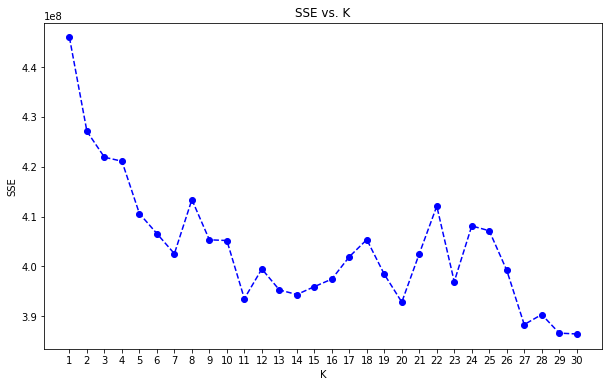

In [34]:
# Investigate the change in within-cluster distance across number of clusters.

plt.figure(figsize=(10, 6))
ax = plt.subplot()
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.xticks(np.arange(1, 31, step=1))
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [78]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=30, random_state=42, n_jobs=-1)
azdias_preds = kmeans.fit_predict(azdias_pca)

In [79]:
azdias_cluster = pd.DataFrame(np.round(azdias_pca, 4), columns = dimensions)
azdias_cluster.insert(loc=0, column='Cluster', value=azdias_preds)
azdias_cluster.head()

,Cluster,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,...,Dimension 283,Dimension 284,Dimension 285,Dimension 286,Dimension 287,Dimension 288,Dimension 289,Dimension 290,Dimension 291,Dimension 292
0,2,-1.2548,2.1521,-2.1340,-2.7374,1.0617,-4.1056,-0.5751,-2.9381,-1.9873,...,-0.0007,-0.1498,-0.2706,0.0937,-0.1906,0.3455,-0.2621,0.5731,0.1756,-0.0806
1,12,-4.7593,0.4323,7.5681,-4.3704,-0.5865,1.3026,-4.9884,1.0977,3.1803,...,-0.0977,0.1590,0.2429,0.5820,-2.1246,-0.6086,-0.0927,-0.7935,-1.0019,0.0370
2,22,0.9078,2.0304,2.2464,-3.0913,4.5353,0.8538,2.9728,7.6598,0.4989,...,0.2233,-0.3215,1.2137,-0.5087,0.6266,0.6203,-0.7882,-0.7044,-0.0713,0.2037
3,21,6.0476,2.7199,-3.2177,-3.2817,-1.9103,1.9171,-2.6043,1.4118,-0.4108,...,-0.4607,0.5864,0.6807,-0.6316,0.0067,1.0483,-0.6258,-1.1641,-0.6490,0.2546
4,19,3.3865,-1.4841,5.8456,9.0864,-2.8964,-0.6151,2.2235,0.4017,-4.6197,...,-1.1577,-0.0789,2.7114,-0.3033,-1.1370,-1.7539,-0.5315,0.5814,-0.9583,0.7990


### Discussion 3.1 Apply Clustering to General Population
Instead of using KMeans class to perform k-means clustering on the PCA-transformed data for a number of different cluster counts, an alternative called MiniBatchKMeans was used instead. The user guide says that it uses mini-batches to reduce the computation time, while still attempting to optimise the same objective function. MiniBatchKMeans converges faster than KMeans, but the quality of the results is reduced. In practice this difference in quality can be quite small. The algorithm did not resolve after one hour for KMeans, hence the variant MiniBatchKMeans was used to provide a significantly faster solution.

The scree plot shows that the score or the sum of the squared errors (SSE) generally decreased as the number of clusters increased. As the instruction suggested, the maximum clusters used was 30. The 'elbow method' is not applicable in the plot because there is no visible leveling observed. Even though 30 clusters did not produce the lowest SSE, it was still used as the number of clusters for the full KMeans clustering operation.



### Step 3.2 Apply All Steps to the Customer Data
Now that the clusters and cluster centers for the general population have been obtained, it's time to see how the customer data maps on to those clusters. The fits from the general population will be used to clean, transform, and cluster the customer data. In the last step, there will be an interperation on how the general population fits apply to the customer data.



In [5]:
# This is to set the object type since these two columns are mixed type
dtypes = {"CAMEO_DEUG_2015": object, "CAMEO_INTL_2015": object}

In [24]:
customers_clean = clean_data(customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1))

In [80]:
# Check for missing column in `customers_clean`
missing = list(np.setdiff1d(azdias_clean.columns, customers_clean.columns))
missing

['ALTERSKATEGORIE_FEIN_1.0',
 'EINGEZOGENAM_HH_JAHR_1900.0',
 'EINGEZOGENAM_HH_JAHR_1904.0',
 'EINGEZOGENAM_HH_JAHR_1971.0',
 'EINGEZOGENAM_HH_JAHR_1984.0',
 'GEBAEUDETYP_5.0']

In [85]:
# Add the missing column with default value of 0
for m in missing:
    customers_clean[m] = 0
    customers_clean[m] = customers_clean[m].astype('uint8')

In [86]:
# Apply feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_pca = pca.transform(scaler.transform(imputer.transform(customers_clean)))
customers_preds = kmeans.predict(customers_pca)

In [87]:
customers_cluster = pd.DataFrame(np.round(customers_pca, 4), columns = dimensions)
customers_cluster.insert(loc=0, column='Cluster', value=customers_preds)

### Step 3.3 Compare Customer Data to Demographics Data
At this point, there are clustered data based on demographics of the general population of Germany, and the customer data for a mail-order sales company has been mapped onto those demographic clusters. In this final substep, the two cluster distributions will be compared to see where the strongest customer base for the company is.

In [91]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def show_proportion(df_cluster, title='Default Title'):    
    #get order of bars by frequency
    cluster_counts = df_cluster['Cluster'].value_counts()
    cluster_order = cluster_counts.index

    #compute largest proportion
    n_model = df_cluster.shape[0]
    max_cluster_count = cluster_counts.iloc[0]
    max_prop = max_cluster_count / n_model

    #establish tick locations and create plot
    base_color = sns.color_palette()[0]
    tick_props = np.arange(0, max_prop, 0.02)
    tick_names = ['{:0.2f}'.format(v) for v in tick_props]

    base_color = sns.color_palette()[0]
    sns.countplot(data=df_cluster, y='Cluster', color=base_color, order=cluster_order)
    plt.xticks(tick_props * n_model, tick_names)
    plt.xlabel('proportion')
    plt.title(title);

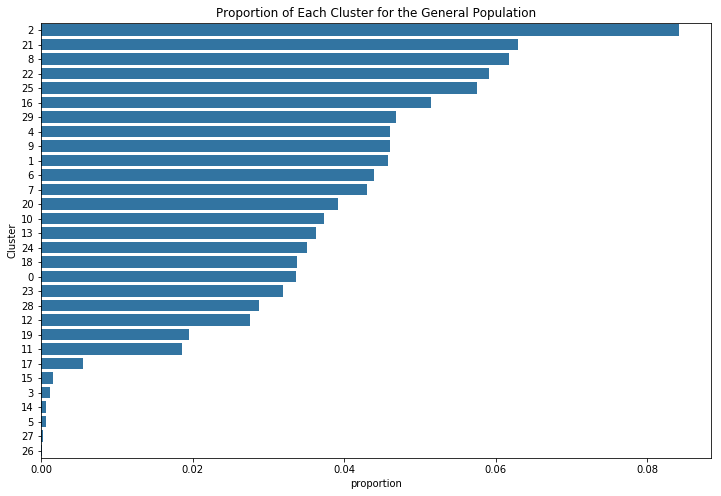

In [92]:
fig, ax = plt.subplots(figsize=(12,8))
show_proportion(azdias_cluster, title='Proportion of Each Cluster for the General Population')

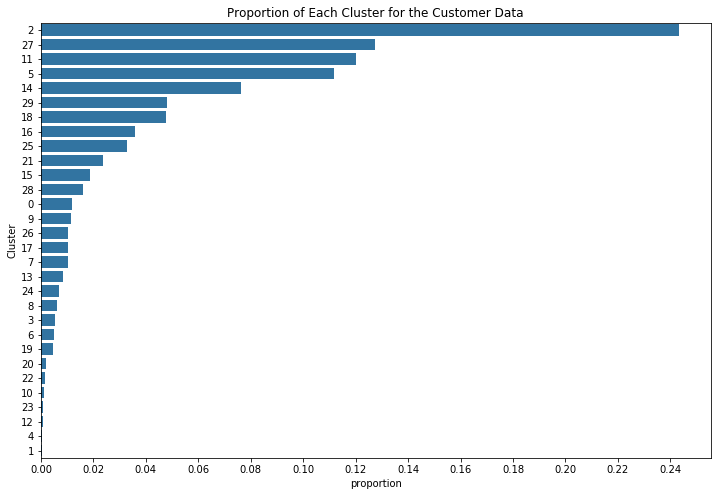

In [93]:
fig, ax = plt.subplots(figsize=(12,8))
show_proportion(customers_cluster, title='Proportion of Each Cluster for the Customer Data')

In [94]:
# Check for overrepresentation and underrepresentation of clusters between the two datasets
azdias_prop = azdias_cluster['Cluster'].value_counts() / azdias_cluster.shape[0]
customers_prop = customers_cluster['Cluster'].value_counts() / customers_cluster.shape[0]
diff_prop = customers_prop - azdias_prop

max_index = diff_prop.sort_values(ascending=False).index[0]
max_diff = diff_prop.sort_values(ascending=False).iloc[0]
min_index = diff_prop.sort_values(ascending=False).index[-1]
min_diff = diff_prop.sort_values(ascending=False).iloc[-1]

In [95]:
diff_prop.sort_values(ascending=False)

2     0.159083
27    0.127258
5     0.111100
11    0.101728
14    0.075712
15    0.017186
18    0.014055
26    0.010305
17    0.004959
3     0.004144
29    0.001299
28   -0.012723
19   -0.014732
16   -0.015704
0    -0.021700
25   -0.024521
12   -0.026874
13   -0.027915
24   -0.028154
23   -0.031148
7    -0.032572
9    -0.034561
10   -0.036342
20   -0.037286
6    -0.039143
21   -0.039233
1    -0.045384
4    -0.045589
8    -0.055763
22   -0.057486
Name: Cluster, dtype: float64

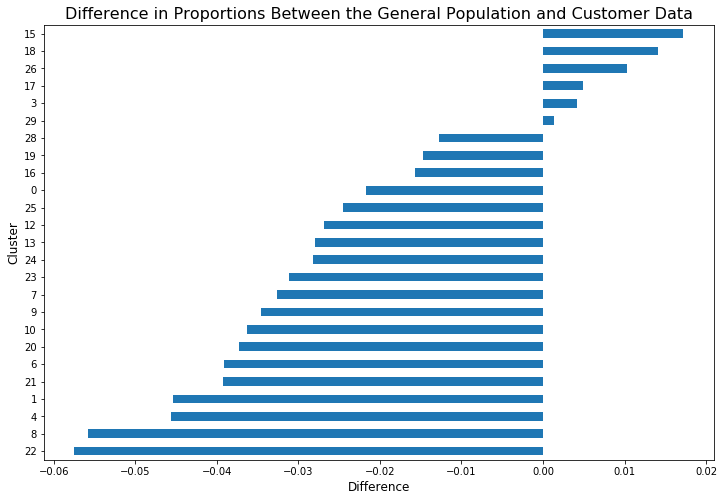

In [96]:
fig, ax = plt.subplots(figsize=(12,8))
diff_prop.sort_values()[:25].plot.barh(color=sns.color_palette()[0])
plt.title("Difference in Proportions Between the General Population and Customer Data", fontsize=16)
plt.xlabel("Difference", fontsize=12)
plt.ylabel("Cluster", fontsize=12);

In [101]:
# Function to transform centroids back to the original data space based on cluster number
def infer_cluster(index):
    
    # Subset the customers_cluster dataframe by the selected index
    cluster = customers_cluster[customers_cluster['Cluster'] == index]
    cluster_drop = cluster.drop('Cluster', axis=1)
    
    # Perform inverse PCA and inverse scaling to return to the original values
    cluster_pca = pca.inverse_transform(cluster_drop)
    cluster_scaler = scaler.inverse_transform(cluster_pca)
    
    # Create a new dataframe of the cluster and reuse the feature columns
    cluster_final = pd.DataFrame(cluster_scaler, columns=customers_clean.columns)
    return cluster_final

In [102]:
# Columns to infer based on Step 2.3
infer_columns = ['MOBI_REGIO',
                 'PLZ8_ANTG1',
                 'PLZ8_ANTG3',
                 'KBA13_HERST_BMW_BENZ',
                 'FINANZ_VORSORGER',
                 'KBA13_MERCEDES',
                 'KBA13_SITZE_5',
                 'DECADE',
                 'FINANZ_ANLEGER',
                 'ALTERSKATEGORIE_GROB']


In [103]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
print('The cluster which is the most overrepresented is cluster {} with a difference of {}.'
         .format(max_index, np.round(max_diff, 4)))


The cluster which is the most overrepresented is cluster 2 with a difference of 0.1591.


In [104]:
over_cluster = infer_cluster(max_index)
print(over_cluster.shape)
over_cluster.head()

(46609, 584)


,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,...,NATIONO,NATIONW,WEALTH,LIFE_STAGE,ALTERSKATEGORIE_FEIN_1.0,EINGEZOGENAM_HH_JAHR_1900.0,EINGEZOGENAM_HH_JAHR_1904.0,EINGEZOGENAM_HH_JAHR_1971.0,EINGEZOGENAM_HH_JAHR_1984.0,GEBAEUDETYP_5.0
0,4.287023,7.996959,-0.019339,0.071828,1.709298,6.917725,0.006994,3.153675,3.948553,4.732981,...,-0.168377,-0.007350,0.083241,0.107942,7.294895,0.738054,0.028544,-0.021859,2.423266,1.954876
1,4.268285,8.151012,-0.021233,0.076368,1.714006,7.047747,0.006941,3.144206,3.936992,4.791429,...,-0.162219,-0.009917,0.082169,0.109727,7.219101,0.741956,0.007691,-0.038298,2.425131,1.949276
2,4.277656,8.073728,-0.020283,0.074108,1.711644,6.982516,0.006969,3.148946,3.942803,4.762192,...,-0.165285,-0.008624,0.082695,0.108834,7.257012,0.740020,0.018116,-0.030075,2.424204,1.952123
3,4.284158,8.148191,-0.013736,0.078717,1.704564,7.035682,0.006784,3.149391,3.948022,4.879342,...,-0.165575,-0.014296,0.075640,0.108650,7.375074,0.732276,0.023352,-0.029203,2.428186,1.956136
4,4.265316,8.301738,-0.015657,0.083242,1.709260,7.165243,0.006727,3.139881,3.936411,4.937755,...,-0.159403,-0.016861,0.074567,0.110430,7.299326,0.736165,0.002519,-0.045623,2.429995,1.950531


In [105]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
print('The cluster which is the most underrepresented is cluster {} with a difference of {}.'
         .format(min_index, np.round(min_diff, 4)))

The cluster which is the most underrepresented is cluster 22 with a difference of -0.0575.


In [106]:
under_cluster = infer_cluster(min_index)
print(under_cluster.shape)
under_cluster.head()

(311, 584)


,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,...,NATIONO,NATIONW,WEALTH,LIFE_STAGE,ALTERSKATEGORIE_FEIN_1.0,EINGEZOGENAM_HH_JAHR_1900.0,EINGEZOGENAM_HH_JAHR_1904.0,EINGEZOGENAM_HH_JAHR_1971.0,EINGEZOGENAM_HH_JAHR_1984.0,GEBAEUDETYP_5.0
0,5.576272,-2.132306,-0.252920,0.315322,2.365947,-1.017139,-0.000291,3.076833,7.685191,3.158006,...,-2.478256,-0.746519,-1.025719,1.777790,11.080400,1.571942,0.513849,0.622202,4.242798,3.256140
1,6.028834,11.853533,-0.325225,0.264052,2.199753,10.942538,-0.037375,2.948287,4.306198,1.987266,...,-2.207190,-0.716258,-0.927886,1.858599,10.357553,1.404690,0.047109,0.181081,3.571316,2.616337
2,5.066608,6.907013,-0.553179,0.526808,2.501283,6.789278,-0.029554,3.278369,3.805936,2.440545,...,-2.355669,-1.169344,-0.787017,1.883186,10.635072,1.286068,0.628643,0.684287,4.148320,2.923763
3,6.456376,3.566663,-0.339069,0.513826,2.136156,2.720941,-0.031403,2.629883,3.995716,2.348856,...,-2.548791,-0.697880,-0.774510,1.419145,10.833891,1.399076,0.526244,0.567158,3.215777,2.278159
4,7.398801,1.969565,-0.339958,0.380207,2.394361,1.971328,-0.020944,4.402752,1.973936,3.164662,...,-2.037853,-0.235159,0.146335,0.015224,10.773862,1.237616,0.538502,0.605771,3.632275,1.214327


In [107]:
# Compare the differences between the target and non-target groups
over_mean = over_cluster[infer_columns].describe().loc['mean']
under_mean = under_cluster[infer_columns].describe().loc['mean']
mean_df = pd.concat([over_mean, under_mean], axis=1)
mean_df.columns = ['Target', 'Non-Target']

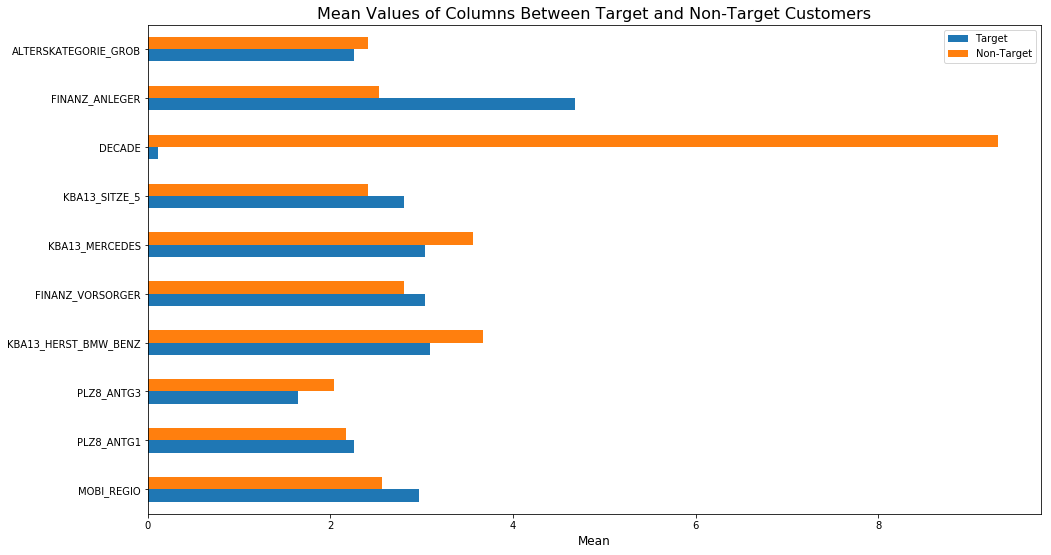

In [108]:
# Plot the means of the columns of interests for the target and non-target groups
fig, ax = plt.subplots(figsize=(16,9))
plt.title("Mean Values of Columns Between Target and Non-Target Customers", fontsize=16)
plt.xlabel("Mean", fontsize=12)
mean_df.plot.barh(ax=ax);

### Discussion 3.3 Compare Customer Data to Demographics Data
Since there are over 595 features, it will be impractical to check each feature to interpret the two clusters. Based on the principal component interpretations from step 2.3, the columns to be interpreted on the original data of the chosen clusters can be identified.

Only three out of the nine features above are clearly different. These are D19_GESAMT_ANZ_24, DECADE, and MOBI_REGIO. The target customers are less mobile, less recent dominating movement in their youths which probably means they are older, and have very low to none transactions in the past 24 months.

# Part 2: Supervised Learning Model
Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [6]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype=dtypes)
mailout_train.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


## Exploring the Data
The last column RESPONSE will be the target label (whether or not the customer becamse a customer or not). All other applicable columns are features about each individual in the mailout campaign.

In [7]:
# Total number of records
n_records = mailout_train.shape[0]

# Number of records where the individual became a customer
n_customer = mailout_train[mailout_train['RESPONSE'] == 1].shape[0]

# Number of records where individual did not become a customer
n_not_customer = mailout_train[mailout_train['RESPONSE'] == 0].shape[0]

# Percentage of individuals who became customers
customer_perc = (n_customer / n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals who became customers: {}".format(n_customer))
print("Individuals who did not become customers: {}".format(n_not_customer))
print("Percentage of individuals who became customers: {}%".format(customer_perc))

Total number of records: 42962
Individuals who became customers: 532
Individuals who did not become customers: 42430
Percentage of individuals who became customers: 1.2383036171500394%


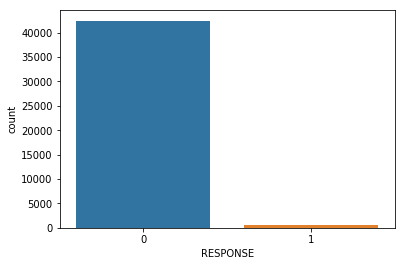

In [8]:
sns.countplot("RESPONSE",data=mailout_train)

Out of all the 42,962 individuals in the mailout campaign, only 1.24% of the individuals became customers. The dataset is highly imbalanced because of the disproportionate amount of customers and non-customers.

## Preparing the Data
Before the imbalanced dataset can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as preprocessing. Fortunately, the features are similar to the general population dataset and the customers dataset.

In [22]:
# Prepare the data using the function created earlier
mailout_train_clean = clean_data(mailout_train)

In [25]:
# Check for missing column in `clean_mailout_train`
missing = list(np.setdiff1d(customers_clean.columns, mailout_train_clean.columns))
missing

[]

In [26]:
# Add the missing column with default value of 0
for m in missing:
    mailout_train_clean[m] = 0
    mailout_train_clean[m] = mailout_train_clean[m].astype('uint8')
mailout_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 579 entries, AKT_DAT_KL to LIFE_STAGE
dtypes: float64(322), int64(1), uint8(256)
memory usage: 116.4 MB


In [27]:
# Split the data into features and target label
response_raw = mailout_train_clean['RESPONSE']
features_raw = mailout_train_clean.drop('RESPONSE', axis = 1)

## Shuffle and Split the Data
Now, the dataset has been preprocessed and is now ready for machine learning. As always, we will now split the data (both features and their labels) into training and test sets. Due to class imbalance, a variation of KFold that returns stratified folds will be implemented. The folds made will preserve the percentage of samples for each class.

In [28]:
# Import StratifiedKFold
from sklearn.model_selection import StratifiedKFold

# Initialize 5 stratified folds
skf = StratifiedKFold(n_splits=5, random_state=28)
skf.get_n_splits(features_raw, response_raw)
print(skf)

StratifiedKFold(n_splits=5, random_state=28, shuffle=False)


## Evaluating Model Performance
Since there is a large output class imbalance, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the model will be using ROC-AUC to evaluate performance.

Aside from the Kaggle competition (see section below) using ROC-AUC as the score, the metric is suitable for binary classification problems such as this. Jason Brownlee, in his article explains that "ROC curves give us the ability to assess the performance of the classifier over its entire operating range. The most widely-used measure is the area under the curve (AUC). The AUC can be used to compare the performance of two or more classifiers. A single threshold can be selected and the classifiers’ performance at that point compared, or the overall performance can be compared by considering the AUC". Compared to the F1 score, the ROC does not require optimizing a threshold for each label.

There are a number of approaches to deal with class imbalance which have been already explained by numerous blog posts from different experts. This particular article from Analytics Vidhya describes the following techniques:

* Random Over-sampling
* Random Under-sampling
* Cluster-Based Over-sampling
* Informed Over Sampling: Synthetic Minority Over-sampling Technique (SMOTE)
* Modified synthetic minority oversampling technique (MSMOTE)

The above approaches deals with handling imbalanced data by resampling original data to provide balanced classes. The same article also provides an alternative approach of modifying existing classification algorithms to make them appropriate for imbalanced data sets.

* Bagging-Based
* Boosting-Based
* Adaptive Boosting
* Gradient Tree Boosting
* Extreme Gradient Boosting
* Light GBM

The last four algorithms will be investigated to determine which is best at modeling the data.

In [29]:
# Import libraries for machine learning pipeline
from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Tree Boosting
from xgboost.sklearn import XGBRegressor # Extreme Gradient Boosting
clf_A = AdaBoostRegressor(random_state=66)
clf_B = GradientBoostingRegressor(random_state=66)
clf_C = XGBRegressor(random_state=66)

In [34]:
model_scores = {}

for i, clf in enumerate([clf_A, clf_B, clf_C]):

    # Create machine learning pipeline
    pipeline = Pipeline([
        ('imp', imputer),
        ('scale', scaler),
        ('clf', clf)
    ])

    scores = []
    j = 0

    # Perform 5-fold validation
    for train_index, test_index in skf.split(features_raw, response_raw):
        j+=1
        print('Classifier {}: Fold {}...'.format(i+1, j))
        
        # Split the data into training and test sets
        X_train, X_test = features_raw.iloc[train_index], features_raw.iloc[test_index]
        y_train, y_test = response_raw.iloc[train_index], response_raw.iloc[test_index]

        # Train using the pipeline
        pipeline.fit(X_train, y_train)

        #Predict on the test data
        y_pred = pipeline.predict(X_test)

        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
        print(score)

    model_scores[clf] = scores

Classifier 1: Fold 1...
0.747540203655939
Classifier 1: Fold 2...
0.7319625947960466
Classifier 1: Fold 3...
0.7884412283939363
Classifier 1: Fold 4...
0.7438867124097848
Classifier 1: Fold 5...
0.7477382281137857
Classifier 2: Fold 1...
0.7209218702161448
Classifier 2: Fold 2...
0.7478425157653839
Classifier 2: Fold 3...
0.8003465196839189
Classifier 2: Fold 4...
0.7423731206559973
Classifier 2: Fold 5...
0.771722237292055
Classifier 3: Fold 1...


/Users/zhongming/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.7169020552818165
Classifier 3: Fold 2...


/Users/zhongming/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.7517450402091626
Classifier 3: Fold 3...


/Users/zhongming/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.7914711911739203
Classifier 3: Fold 4...


/Users/zhongming/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.7371453092551995
Classifier 3: Fold 5...


/Users/zhongming/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.7744598206146417


In [35]:
scores_df = pd.DataFrame(model_scores)
scores_df.columns = ['AdaBoostRegressor', 'GradientBoostingRegressor', 'XGBRegressor']
scores_df

,AdaBoostRegressor,GradientBoostingRegressor,XGBRegressor
0,0.747540,0.720922,0.716902
1,0.731963,0.747843,0.751745
2,0.788441,0.800347,0.791471
3,0.743887,0.742373,0.737145
4,0.747738,0.771722,0.774460


In [36]:
scores_df.describe()

,AdaBoostRegressor,GradientBoostingRegressor,XGBRegressor
count,5.000000,5.000000,5.000000
mean,0.751914,0.756641,0.754345
std,0.021409,0.030391,0.029528
min,0.731963,0.720922,0.716902
25%,0.743887,0.742373,0.737145
50%,0.747540,0.747843,0.751745
75%,0.747738,0.771722,0.774460
max,0.788441,0.800347,0.791471


## Improving Results
Among the three models namely AdaBoostRegressor, GradientBoostingRegressor, and XGBRegressor, the middle one performed best based on the mean score. It beat out the other two models by a small margin. But i would like to try XGBoost first because of the speed.

In [37]:
# Create function to make a machine learning pipeline

def create_pipeline(clf):
    
    # Create machine learning pipeline
    pipeline = Pipeline([
        ('imp', imputer),
        ('scale', scaler),
        ('clf', clf)
    ])
    
    return pipeline

In [38]:
# Create function to do 5-fold cross-validation above

def cross_validate(clf):

    pipeline = create_pipeline(clf)
    scores = []
    i = 0

    # Perform 5-fold validation
    for train_index, test_index in skf.split(features_raw, response_raw):
        i+=1
        print('Fold {}'.format(i))
        
        # Split the data into training and test sets
        X_train, X_test = features_raw.iloc[train_index], features_raw.iloc[test_index]
        y_train, y_test = response_raw.iloc[train_index], response_raw.iloc[test_index]

        # Train using the pipeline
        pipeline.fit(X_train, y_train)

        #Predict on the test data
        y_pred = pipeline.predict(X_test)

        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
        print("Score: {}".format(score))
        
    return scores

In [39]:
# Create initial model
clf_0 = XGBRegressor(
    objective = 'binary:logistic', #logistic regression for binary classification
    scale_pos_weight = 1, #because of high class imbalance
    random_state = 28)


In [106]:
tuned_scores0 = cross_validate(clf_0)

Fold 1


/Users/zhongming/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score: 0.7202192285920075
Fold 2


/Users/zhongming/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score: 0.7487142098805951
Fold 3


/Users/zhongming/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score: 0.7941520773393691
Fold 4


/Users/zhongming/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score: 0.7462996767150334
Fold 5


/Users/zhongming/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score: 0.7543234361590011


In [107]:
np.array(tuned_scores0).mean()

0.7527417257372012

## Tune Model

In [40]:
pipeline = Pipeline([
        ('imp', imputer),
        ('scale', scaler),
        ('clf', clf_0)
])

parameters_1 = {
    'clf__max_depth': range(3,10,2),
    'clf__min_child_weight': range(1,6,2)
}

cv = GridSearchCV(estimator=pipeline, param_grid=parameters_1, scoring='roc_auc',n_jobs=-1, iid=False, cv=5)
cv.fit(features_raw, response_raw)
cv.grid_scores_, cv.best_params_, cv.best_score_

/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:6

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [41]:
cv.best_params_, cv.best_score_

({'clf__max_depth': 3, 'clf__min_child_weight': 5}, 0.7550706717303969)

In [42]:
#Update model
clf_1 = XGBRegressor(
    max_depth = 3,
    min_child_weight = 5,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    random_state = 28)

pipeline = Pipeline([
        ('imp', imputer),
        ('scale', scaler),
        ('clf', clf_1)
])

parameters_2 = {
    'clf__gamma': [i/10.0 for i in range(0,5)]
}

cv = GridSearchCV(estimator=pipeline, param_grid=parameters_2, scoring='roc_auc',n_jobs=-1, iid=False, cv=5)
cv.fit(features_raw, response_raw)
_

/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:6

({'clf__max_depth': 3, 'clf__min_child_weight': 5}, 0.7550706717303969)

In [46]:
cv.best_params_

{'clf__gamma': 0.1}

In [47]:
clf_2 = XGBRegressor(
    gamma = 0.1,
    max_depth = 3,
    min_child_weight = 5,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    random_state = 28)

In [48]:
pipeline = Pipeline([
        ('imp', imputer),
        ('scale', scaler),
        ('clf', clf_2)
])

parameters_3 = {
    'clf__subsample':[i/10.0 for i in range(6,10)],
    'clf__colsample_bytree':[i/10.0 for i in range(6,10)]
}

cv = GridSearchCV(estimator=pipeline, param_grid=parameters_3, scoring='roc_auc',n_jobs=-1, iid=False, cv=5)
cv.fit(features_raw, response_raw)

/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:6

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        Imputer(axis=0, copy=True,
                                                missing_values='NaN',
                                                strategy='mean', verbose=0)),
                                       ('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gbtree',
                                                     colsample_bylevel=1,
                                                     colsample_bytree=1,
                                                 

In [49]:
cv.best_params_

{'clf__colsample_bytree': 0.7, 'clf__subsample': 0.6}

In [50]:
clf_3 = XGBRegressor(
    subsample = 0.6,
    colsample_bytree = 0.7,
    gamma = 0.1,
    max_depth = 3,
    min_child_weight = 5,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    random_state = 28)
pipeline = Pipeline([
        ('imp', imputer),
        ('scale', scaler),
        ('clf', clf_3)
])

parameters_4 = {
    'clf__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

cv = GridSearchCV(estimator=pipeline, param_grid=parameters_4, scoring='roc_auc',n_jobs=-1, iid=False, cv=5)
cv.fit(features_raw, response_raw)

/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:6

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        Imputer(axis=0, copy=True,
                                                missing_values='NaN',
                                                strategy='mean', verbose=0)),
                                       ('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gbtree',
                                                     colsample_bylevel=1,
                                                     colsample_bytree=0.7,
                                               

In [51]:
cv.best_params_

{'clf__reg_alpha': 1e-05}

In [52]:
clf_4 = XGBRegressor(
    reg_alpha = 1e-05,
    subsample = 0.6,
    colsample_bytree = 0.7,
    gamma = 0.1,
    max_depth = 3,
    min_child_weight = 5,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    random_state = 28)
pipeline = Pipeline([
        ('imp', imputer),
        ('scale', scaler),
        ('clf', clf_4)
])

parameters_5 = {
    'clf__reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

cv = GridSearchCV(estimator=pipeline, param_grid=parameters_5, scoring='roc_auc',n_jobs=-1, iid=False, cv=5)
cv.fit(features_raw, response_raw)

/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/zhongming/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:6

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        Imputer(axis=0, copy=True,
                                                missing_values='NaN',
                                                strategy='mean', verbose=0)),
                                       ('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gbtree',
                                                     colsample_bylevel=1,
                                                     colsample_bytree=0.7,
                                               

In [53]:
cv.best_params_

{'clf__reg_alpha': 0.05}

In [55]:
clf_4 = XGBRegressor(
    learning_rate = 0.01,
    n_estimators = 1000,
    reg_alpha = 0.05,
    subsample = 0.6,
    colsample_bytree = 0.7,
    gamma = 0.1,
    max_depth = 3,
    min_child_weight = 5,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    random_state = 28)
final_scores = cross_validate(clf_4)

Fold 1


/Users/zhongming/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score: 0.751371142354312
Fold 2


/Users/zhongming/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score: 0.7629961167486414
Fold 3


/Users/zhongming/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score: 0.8170227099907061
Fold 4


/Users/zhongming/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score: 0.758417304417042
Fold 5


/Users/zhongming/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score: 0.7708128593599224


In [56]:
np.array(final_scores).mean()

0.7721240265741247

## Check Most Important Features

In [57]:
def feature_plot(importances, X_train, y_train, num_feat=5):
     
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:num_feat]]
    values = importances[indices][:num_feat]
 
    # Create the plot
    fig = plt.figure(figsize = (16,9))
    plt.title("Normalized Weights for the Most Predictive Features", fontsize = 16)
    plt.barh(np.arange(num_feat), values[::-1], height = 0.6, align="center", \
          label = "Feature Weight")
    plt.barh(np.arange(num_feat) - 0.3, np.cumsum(values)[::-1], height = 0.2, align = "center", \
          label = "Cumulative Feature Weight")
    plt.yticks(np.arange(num_feat), columns[::-1])
    plt.xlabel("Weight", fontsize = 12)
    plt.ylabel('')
     
    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.show()  

In [58]:
importances = clf_4.feature_importances_

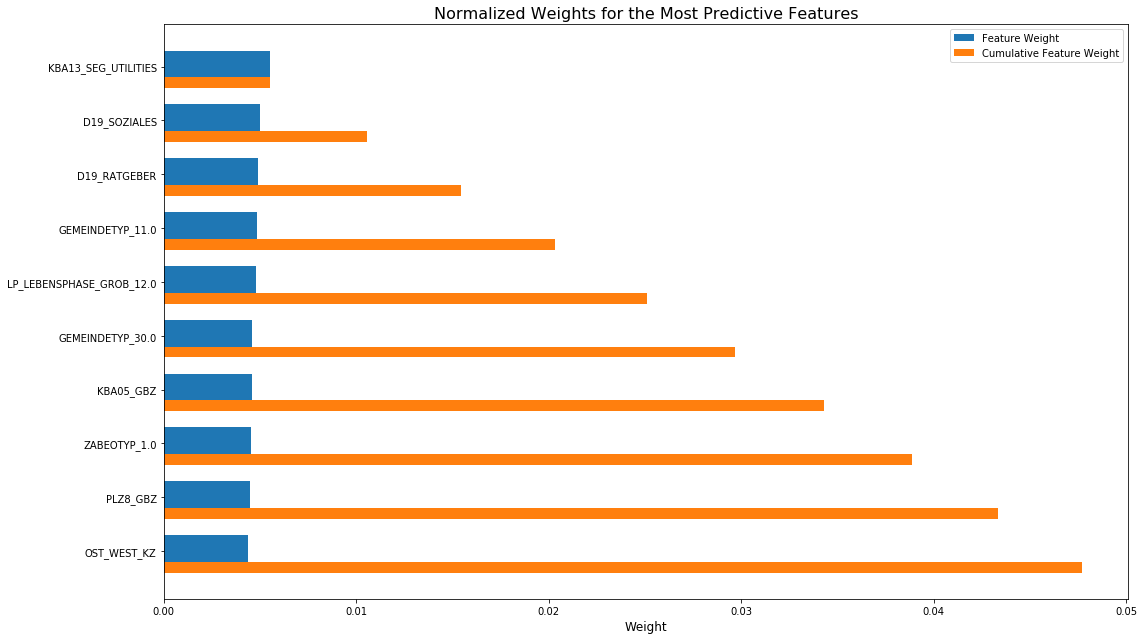

In [59]:
feature_plot(importances, features_raw, response_raw, 10)

# Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link here, you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [60]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype=dtypes)
mailout_test.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [61]:
mailout_test_clean = clean_data(mailout_test)

In [62]:
# Check for missing column in `clean_mailout_test`
missing = list(np.setdiff1d(customers_clean.columns, mailout_test_clean.columns))
missing

['EINGEZOGENAM_HH_JAHR_1986.0']

In [63]:
# Add the missing column with default value of 0
for m in missing:
    mailout_test_clean[m] = 0
    mailout_test_clean[m] = mailout_test_clean[m].astype('uint8')
mailout_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 578 entries, AKT_DAT_KL to EINGEZOGENAM_HH_JAHR_1986.0
dtypes: float64(322), uint8(256)
memory usage: 115.7 MB


In [64]:
pipeline = create_pipeline(clf_4)
pipeline.fit(features_raw, response_raw)


/Users/zhongming/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/zhongming/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Pipeline(memory=None,
         steps=[('imp',
                 Imputer(axis=0, copy=True, missing_values='NaN',
                         strategy='mean', verbose=0)),
                ('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bytree=0.7,
                              gamma=0.1, importance_type='gain',
                              learning_rate=0.01, max_delta_step=0, max_depth=3,
                              min_child_weight=5, missing=None,
                              n_estimators=1000, n_jobs=1, nthread=None,
                              objective='binary:logistic', random_state=28,
                              reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1,
                              seed=None, silent=True, subsample=0.6))],
         verbose=False)

In [65]:
#Predict on the test data
predictions = pipeline.predict(mailout_test_clean)

In [66]:
submission = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=predictions)


In [67]:
submission.rename(columns={0: "RESPONSE"}, inplace=True)
submission.head()

,RESPONSE
LNR,
1754,0.034916
1770,0.034423
1465,0.004904
1470,0.004835
1478,0.005489


In [68]:
submission.to_csv('submission.csv')